In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
locloc = "BigDataCubes" 
namename = "\CombinedDatasets\Part0"
all_photos = np.load(locloc + namename + 'Photos.npy')[0:1700]
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')[0:1700]
#all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')[0:1700]
# Цель просто сделать рабочий генератор маски.

In [3]:
def GetDifference(num_images):
    photo = all_photos[num_images]
    albedo = all_albedos[num_images]
    mask = all_masks[num_images]
    return photo - albedo * mask
def normalizeNegativeImage(imim, mask):
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nmax = 0.01
    if nonneg.max() != 0:
        nmax = nonneg.max()
    nonneg = nonneg * (1.0/nmax)
    return nonneg * mask

In [4]:
"""
all_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]
all_masks *= (1.0/all_masks.max())
plt.imshow(all_masks[0])
print(all_masks.shape) """

'\nall_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]\nall_masks *= (1.0/all_masks.max())\nplt.imshow(all_masks[0])\nprint(all_masks.shape) '

In [5]:
def masstestAlt(mylist, locmodel):
    inputs = all_photos[mylist]
    testanswers = all_albedos[mylist]
    imgimg = locmodel.predict([inputs])
    testanswers2 = all_albedos[mylist]
    imgimg2 = locmodel.predict([inputs])
    for i in range(len(mylist)):
        testanswers2[i] = normalizeNegativeImage(all_albedos[mylist[i]], all_masks[mylist[i]])
        imgimg2[i] = normalizeNegativeImage(imgimg[i], all_masks[mylist[i]])

    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(testanswers, axis=1)
    r2 =  np.concatenate(imgimg, axis=1)
    r3 =  np.concatenate(testanswers2, axis=1)
    r4 =  np.concatenate(imgimg2, axis=1)

    
    #r3 =  np.concatenate(np.take(intotheflames, [4,5,6,7], axis=0), axis=0)
    #r4 =  np.concatenate(np.take(imgimg, [4,5,6,7], axis=0), axis=0)
    #r5 =  np.concatenate(np.take(testanswers, [4,5,6,7], axis=0), axis=0)
    finalimage = np.concatenate([r0, r0 - r1, r0 - r2, r3, r4], axis=0)
                                 #r3,r4, r5], 
    return finalimage

In [6]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно

answerList = list()
print(len(all_albedos))
for i in range(len(all_albedos)):
    answerList.append(
        GetDifference(i)
    )               
all_albedos = np.array(answerList)
del answerList;

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_albedos))

dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape)

1700
(1700, 64, 64, 3)


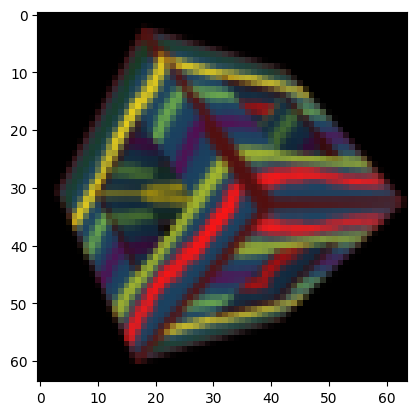

In [7]:
plt.imshow(all_photos[500].astype("float32") - all_albedos[500])

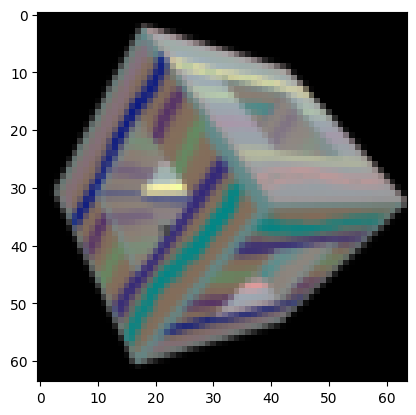

In [8]:
plt.imshow(normalizeNegativeImage(all_albedos[500], all_masks[500]))

In [9]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(x)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(2*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(2*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    #z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    #do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='tanh')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input], outputs=output)
    return model

In [10]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00008)

In [11]:
model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 7)         259       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 7)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1792)              0     

In [21]:
model.fit(train_dataset, epochs=100)

Epoch 1/100
26/26 [==============================] - 1s 13ms/step - loss: 0.0068
Epoch 2/100
26/26 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 3/100
26/26 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 4/100
26/26 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 5/100
26/26 [==============================] - 0s 13ms/step - loss: 0.0068
Epoch 6/100
26/26 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 7/100
26/26 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 8/100
26/26 [==============================] - 0s 14ms/step - loss: 0.0068
Epoch 9/100
26/26 [==============================] - 0s 13ms/step - loss: 0.0067
Epoch 10/100
26/26 [==============================] - 0s 13ms/step - loss: 0.0067
Epoch 11/100
26/26 [==============================] - 0s 15ms/step - loss: 0.0067
Epoch 12/100
26/26 [==============================] - 0s 14ms/step - loss: 0.0068
Epoch 13/100
26/26 [=====

1/1 [==============================] - 0s 24ms/step


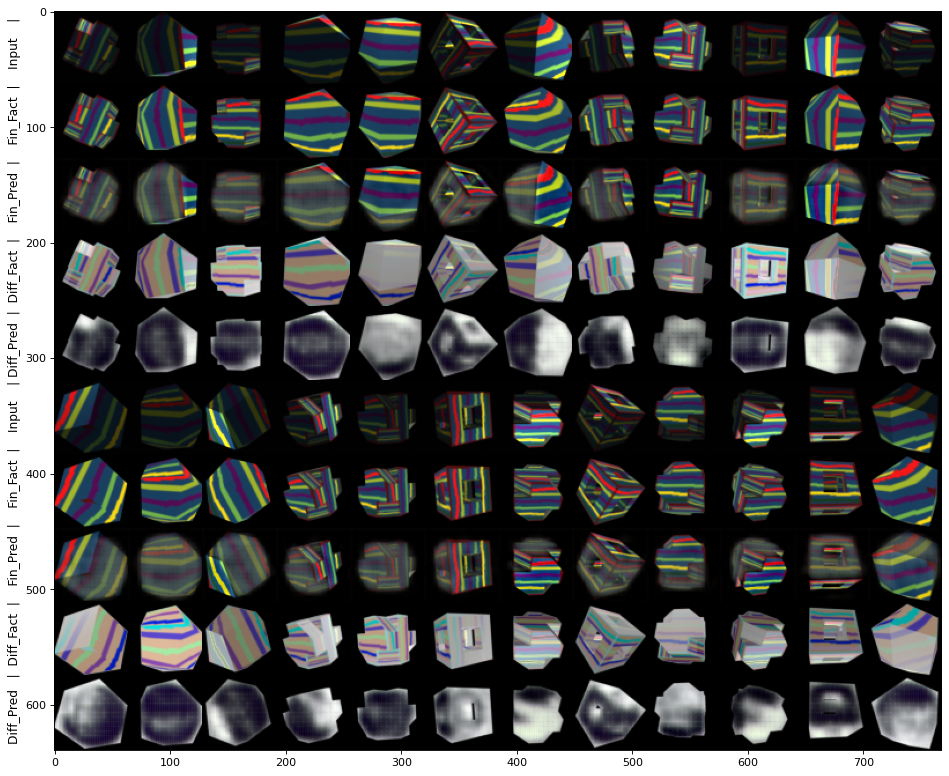

In [23]:
toinset = np.array([i * 100 for i in range(12)])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([i * 100 + 50 for i in range(12)])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(bigpicture.astype("float32").clip(0,1))

In [46]:
model.evaluate(test_photos, test_differences) 

32/32 [==============================] - 0s 13ms/step - loss: 0.0055


0.005453200079500675

1/1 [==============================] - 0s 20ms/step


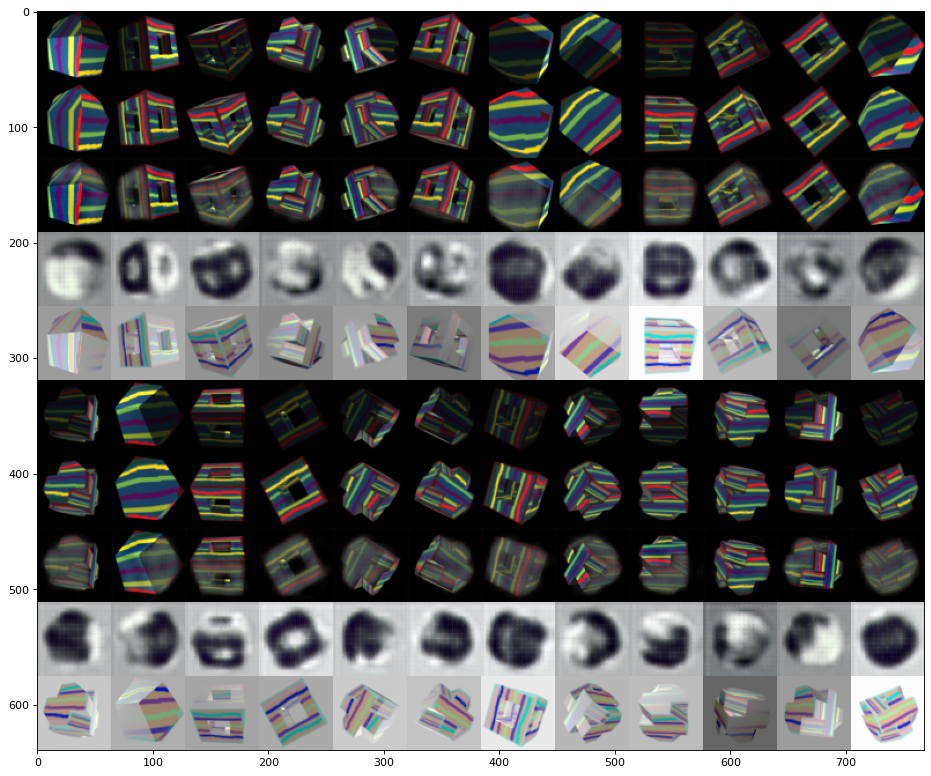

In [45]:
test_predictions = model.predict(test_photos_visual)
actual_differences = np.zeros(test_predictions.shape)
actual_differences_dataset = np.zeros(test_predictions.shape)
for i in range(test_predictions.shape[0]):
    actual_differences[i] = normalizeNegativeImage(test_predictions[i], np.zeros((64,64, 3)) + 1)     
    actual_differences_dataset[i] = normalizeNegativeImage(test_differences_visual[i], np.zeros((64,64, 3)) + 1)    


r0 =  np.concatenate(test_photos_visual[0:12], axis=1)
r1 =  np.concatenate(test_albedos_visual[0:12], axis=1)
r2 =  np.concatenate(test_photos_visual[0:12] - test_predictions[0:12], axis=1)
r3 =  np.concatenate(actual_differences[0:12], axis=1)
r3a = np.concatenate(actual_differences_dataset[0:12], axis=1)
r4 =  np.concatenate(test_photos_visual[12:24], axis=1)
r5 =  np.concatenate(test_albedos_visual[12:24], axis=1)
r6 =  np.concatenate(test_photos_visual[12:24] - test_predictions[12:24], axis=1)
r7 =  np.concatenate(actual_differences[12:24], axis=1)
r7a = np.concatenate(actual_differences_dataset[12:24], axis=1)


finalimage = np.concatenate([r0, r1, r2, r3, r3a, r4, r5, r6, r7, r7a], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(finalimage.clip(0,1))

In [46]:
#model.save("good_universal_normals.keras")
# Попытка 1, 300 эпох. 
# Модель очень даже ничего, она прямо хороша. Тестовая выборка дает отличные результаты. Немного размыто, но не страшно

In [ ]:
plt.imshow()

In [44]:
locloc2 = "BigDataCubes" 
namename2 = "\CombinedDatasets\Part0"
all_test_photos = np.load(locloc2 + namename2 + 'Photos.npy')
test_photos = all_test_photos[0:1000]
test_photos_visual = all_test_photos[1000:1024]
#del all_test_photos;
all_test_albedos = np.load(locloc2 + namename2 + 'Albedos.npy')
test_differences = all_test_photos[0:1000] -  all_test_albedos[0:1000]
test_differences_visual = all_test_photos[1000:1024] -  all_test_albedos[1000:1024]
test_albedos = all_test_albedos[0:1000]
test_albedos_visual = all_test_albedos[1000:1024]
del all_test_albedos; del all_test_photos;

In [21]:
model.save("my_albedos.keras")